In [7]:
import glob
import os
from typing import Any, Dict, List, Tuple, Union

import torch
import torch.nn as nn
import yaml
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder, VisionDataset

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision

In [8]:
device = 'cuda'
lr = 0.0001
num_epoch = 100
l1_weight = 0.0001

input_size = 128 #224//2
batch_size = 128
n_worker = 8

In [9]:
import torchvision.transforms.functional as TF
import random

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 180, 90, 270])

In [10]:
normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225])

train_dataset = ImageFolder(
    "/opt/ml/data/train", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.5, hue=0.1),
        MyRotationTransform(angles=[0, 180, 90, 270]),
        transforms.ToTensor(),
        normalize,
    ]))

val_dataset = ImageFolder("/opt/ml/data/val", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.Resize(int(input_size/0.875)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ]))

In [11]:
from torch.utils.data.sampler import WeightedRandomSampler

sample_freq = [1169, 4826, 1020, 2655, 4879, 1092] #[0] * len(train_dataset.classes) #df_ff.gender.value_counts().sort_index().to_numpy()
sample_weight = np.concatenate([[1/f]*f for f in sample_freq])
sample_weight = torch.from_numpy(sample_weight)
sampler = WeightedRandomSampler(sample_weight.type('torch.DoubleTensor'), len(sample_weight)//2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


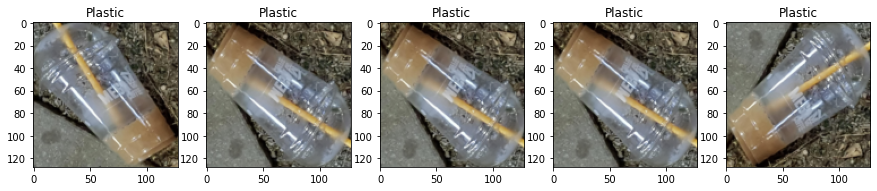

In [12]:
idx = np.random.randint(0, len(train_dataset))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[idx]
    img = img.permute(1,2,0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    axes[i].imshow(img)
    axes[i].set_title(train_dataset.classes[label])
plt.show()

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, drop_last=True, sampler = sampler,
    num_workers=n_worker)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker)

dataloaders = { 'train' : train_loader, 'valid' : val_loader}

In [14]:
from sklearn.metrics import f1_score

@torch.no_grad()
def validate(model, val_loader):
    
    model.eval()
    
    y_true = []
    y_pred = []
    
    running_cnt = running_loss = running_corrects = 0
    
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #inputs = torch.nn.functional.interpolate(inputs, size=112, mode='bilinear', align_corners=False)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #loss = criterion(outputs, labels)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

        running_cnt += inputs.size(0)
        #running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    #epoch_loss = running_loss / running_cnt
    epoch_acc = running_corrects.double() / running_cnt
    f1 = f1_score(y_true, y_pred, average='macro')

    print('Acc: {:.4f} F1: {:.4f}'.format(epoch_acc, f1))

In [16]:
model = CustomVGG()
model.load_state_dict(torch.load('save/vgg9_112_reg.pt'))
model.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPoo

In [ ]:
[[64*0.75], [128*0.75], [256*0.75, 256*0.75], [512*0.75, 512*0.75], [512*0.75, 512*0.75]]

In [21]:
torch.save(model.state_dict(), 'vgg9_fp16.pt')

In [15]:
from model import CustomVGG

device='cuda'

model = CustomVGG()
model.load_state_dict(torch.load('save/vgg9_112_reg.pt'))
model.to(device)

percent = 0.25

total = 0
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        total += m.weight.shape[0]

bn = torch.zeros(total)
index = 0

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        size = m.weight.shape[0]
        bn[index:(index+size)] = m.weight.abs().clone()
        index += size

y, i = torch.sort(bn)

thre_index = int(total * percent)
thre = y[thre_index]
print('threshold =', thre.item())

pruned = 0
cfg = []
cfg_mask = []

for k, m in enumerate(model.modules()):
    if isinstance(m, nn.BatchNorm2d):
        weight_copy = m.weight.abs().clone()
        mask = weight_copy.gt(thre).float().cuda()
        pruned = pruned + mask.shape[0] - torch.sum(mask)
        m.weight.data.mul_(mask)
        m.bias.data.mul_(mask)
        cfg.append(int(torch.sum(mask)))
        cfg_mask.append(mask.clone())
        print('layer index: {:<6d} total channel: {:<6d} remaining channel: {:<6d}'.
            format(k, mask.shape[0], int(torch.sum(mask))))
    elif isinstance(m, nn.MaxPool2d):
        cfg.append('M')

pruned_ratio = pruned/total

validate(model, val_loader)
print(pruned_ratio, 'Pre-processing Successful!')

threshold = 0.2613816559314728
layer index: 3      total channel: 64     remaining channel: 32    
layer index: 7      total channel: 128    remaining channel: 92    
layer index: 11     total channel: 256    remaining channel: 156   
layer index: 14     total channel: 256    remaining channel: 223   
layer index: 18     total channel: 512    remaining channel: 355   
layer index: 21     total channel: 512    remaining channel: 329   
layer index: 25     total channel: 512    remaining channel: 365   
layer index: 28     total channel: 512    remaining channel: 511   
Acc: 0.2466 F1: 0.1008
tensor(0.2504, device='cuda:0') Pre-processing Successful!


In [17]:
import os

In [30]:
print(cfg)

newmodel = vgg_cfg(cfg)
newmodel.cuda()

num_parameters = sum([param.nelement() for param in newmodel.parameters()])
savepath = os.path.join( "prune.txt")

layer_id_in_cfg = 0
start_mask = torch.ones(3)
end_mask = cfg_mask[layer_id_in_cfg]
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.BatchNorm2d):
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        if idx1.size == 1:
            idx1 = np.resize(idx1,(1,))
        m1.weight = nn.Parameter(m0.weight[idx1.tolist()].clone())
        m1.bias = nn.Parameter(m0.bias[idx1.tolist()].clone())
        m1.running_mean = m0.running_mean[idx1.tolist()].clone()
        m1.running_var = m0.running_var[idx1.tolist()].clone()
        layer_id_in_cfg += 1
        start_mask = end_mask.clone()
        if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            end_mask = cfg_mask[layer_id_in_cfg]
    elif isinstance(m0, nn.Conv2d):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))
        if idx1.size == 1:
            idx1 = np.resize(idx1, (1,))
        w1 = m0.weight[:, idx0.tolist(), :, :].clone()
        w1 = w1[idx1.tolist(), :, :, :].clone()
        m1.weight = nn.Parameter(w1.clone())
    elif isinstance(m0, nn.Linear):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))
        m1.weight = nn.Parameter(m0.weight[:, idx0].clone())
        m1.bias = nn.Parameter(m0.bias.clone())

torch.save(newmodel.state_dict(), 'save/pruned.pt')

print(newmodel)
model = newmodel
validate(model, val_loader)

[13, 40, 'M', 40, 93, 'M', 85, 82, 95, 172, 'M', 208, 218, 163, 182, 'M', 304, 311, 233, 512, 'M']
In shape: 3, Out shape 13.
In shape: 13, Out shape 40.
In shape: 40, Out shape 40.
In shape: 40, Out shape 93.
In shape: 93, Out shape 85.
In shape: 85, Out shape 82.
In shape: 82, Out shape 95.
In shape: 95, Out shape 172.
In shape: 172, Out shape 208.
In shape: 208, Out shape 218.
In shape: 218, Out shape 163.
In shape: 163, Out shape 182.
In shape: 182, Out shape 304.
In shape: 304, Out shape 311.
In shape: 311, Out shape 233.
In shape: 233, Out shape 512.
CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(13, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=6) # optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=0.000001)#

In [ ]:
from trainer_reg import Trainer

trainer = Trainer('/opt/ml/code/save', seed=42)

In [ ]:
trainer.train(model, dataloaders, criterion, optimizer, lr_scheduler, num_epoch, 10, l1_weight, 'vgg9_112_reg')